In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.interpolate import CubicSpline
from scipy.signal import hilbert

In [2]:
def extrema(x, l):
    local_max, local_min = [[0], [x[0]]], [[0], [x[0]]]
    for i in range(1, l - 1):
        if x[i - 1] <= x[i] and x[i] >= x[i + 1]:
            local_max[0].append(i)
            local_max[1].append(x[i])
        if x[i - 1] >= x[i] and x[i] <= x[i + 1]:
            local_min[0].append(i)
            local_min[1].append(x[i])
    local_max[0].append(l - 1)
    local_max[1].append(x[l - 1])
    local_min[0].append(l - 1)
    local_min[1].append(x[l - 1])

    if len(local_max[0]) >= 4:
        slope0 = (local_max[1][1] - local_max[1][2]) / (local_max[0][1] - local_max[0][2])
        ref = slope0 * (local_max[0][0] - local_max[0][1]) + local_max[1][1]
        if ref > local_max[1][0]:
            local_max[1][0] = ref

        slopen = (local_max[1][-2] - local_max[1][-3]) / (local_max[0][-2] - local_max[0][-3])
        ref = slopen * (local_max[0][-1] - local_max[0][-2]) + local_max[1][-2]
        if ref > local_max[1][-1]:
            local_max[1][-1] = ref

    if len(local_min[0]) >= 4:
        slope0 = (local_min[1][1] - local_min[1][2]) / (local_min[0][1] - local_min[0][2])
        ref = slope0 * (local_min[0][0] - local_min[0][1]) + local_min[1][1]
        if ref < local_min[1][0]:
            local_min[1][0] = ref

        slopen = (local_min[1][-2] - local_min[1][-3]) / (local_min[0][-2] - local_min[0][-3])
        ref = slopen * (local_min[0][-1] - local_min[0][-2]) + local_min[1][-2]
        if ref < local_min[1][-1]:
            local_min[1][-1] = ref
    return np.array(local_max), np.array(local_min)

In [3]:
def CreateEnvelope(x, N):
    f = CubicSpline(x[0], x[1], bc_type='natural')
    x_new = np.linspace(x[0][0], x[0][-1], N)
    return x_new, f(x_new)

Text(0, 0.5, 'amplitude')

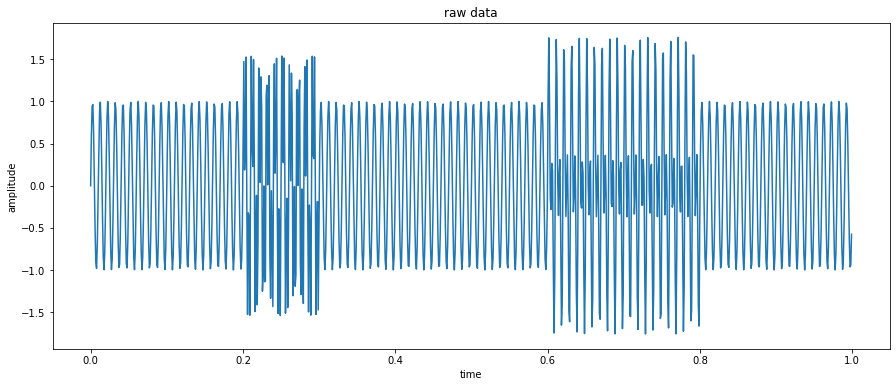

In [6]:
fs = 1024
t = np.arange(0, 1.0, 1.0 / fs)
features = [100,200,300]
intervals = [np.array([tt for tt in t]),
             np.array([tt if (0.6 < tt < 0.8) else 0 for tt in t]),
             np.array([tt if (0.2 < tt < 0.3) else 0 for tt in t]),
            ]
data = np.zeros(shape = (len(t),))
for i in range(len(features)):
    data += np.sin(2 * np.pi * features[i] * intervals[i])
plt.rcParams["figure.figsize"] = (15, 6)
plt.figure()
plt.plot(t,data)
plt.title("raw data")
plt.xlabel("time")
plt.ylabel("amplitude")

In [5]:
xsize, xSTD = len(data), np.std(data, ddof=1)
Nimf = int(np.floor(math.log2(xsize)) - 1) # number of imf
Nallmode = Nimf + 2
allmode = np.zeros(shape=(Nallmode, xsize))
NE, NSTD = 100, 0.4

In [12]:
for ensemble in range(NE):
    x = data / xSTD
    allmode[0] += x

    xorig = np.zeros(shape=(xsize,))

    for i in range(xsize):
        xorig[i] = x[i] + np.random.normal(0, 1, 1) * NSTD

    xend = xorig
    for Nmode in range(1, Nimf + 1):
        xstart = xend
        for sift in range(10):
            local_max, local_min = extrema(xstart, xsize)
            __, MaxEnv = CreateEnvelope(local_max, xsize)
            __, MinEnv = CreateEnvelope(local_min, xsize)
            MeanEnv = (MaxEnv + MinEnv) / 2

            xstart = xstart - MeanEnv
        imf = xstart
        allmode[Nmode] += imf
        xend = xend - imf

    allmode[-1] += xend
allmode = allmode * xSTD / NE

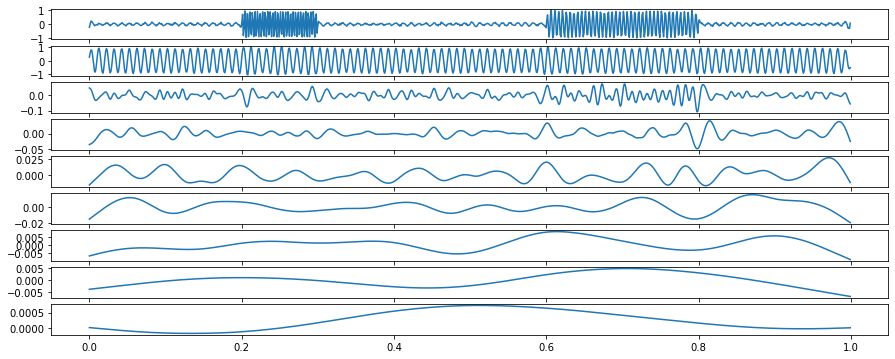

In [18]:
plt.rcParams["figure.figsize"] = (15, 6)
plt.figure()
for i in range(1, Nallmode - 1):
    plt.subplot(Nimf, 1, i)
    plt.plot(t, allmode[i])

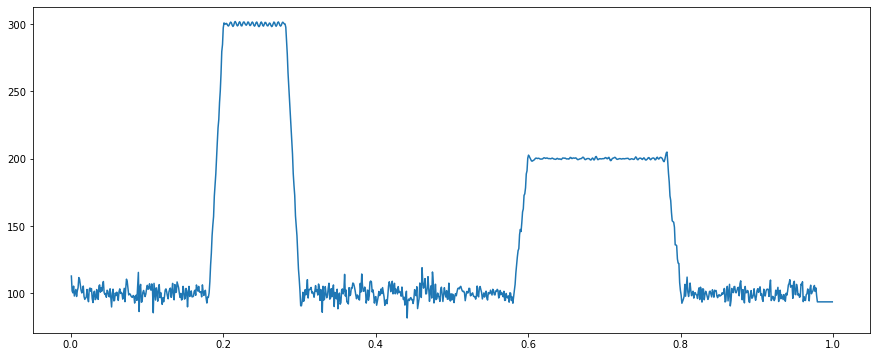

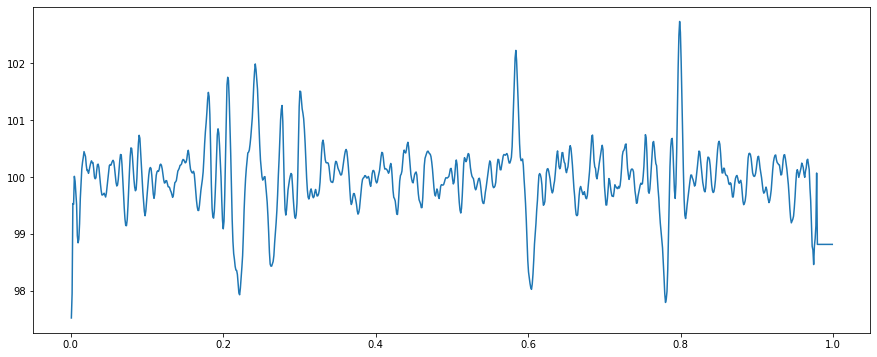

In [28]:
for imf in allmode[1:3]:
    analytic_signal = hilbert(imf)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /
                               (2.0*np.pi) * fs)
    avg_range = 20
    for i in range(0,len(instantaneous_frequency) - avg_range):
        instantaneous_frequency[i] = np.mean(instantaneous_frequency[i:i + avg_range])
    instantaneous_frequency[i + 1:] = instantaneous_frequency[i] 
    plt.rcParams["figure.figsize"] = (15, 6)
    plt.figure()
    plt.plot(t[1:], instantaneous_frequency)
    